# Keyword Classification

## Import Librarys 

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

## Import Data

In [160]:
keywords = pd.read_csv('keywords_categories.csv', encoding = "ISO-8859-1")

#https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python

## EDA

https://github.com/google/eng-edu/blob/main/ml/guides/text_classification/explore_data.py

Number of samples

In [25]:
print(f'Total number of samples = {len(keywords)} keywords')

Total number of samples = 10089 keywords


Number of keywords per class

In [117]:
classes = keywords.pivot_table('keyword', index = 'category', aggfunc='count').sort_values(by='keyword', ascending=False)

In [118]:
classes

,keyword
category,
monotype,2185
font technology,1739
fonts by vertical,936
font,813
html5,702
digital advertising,585
emoji,546
font type,488
mobile advertising,456


Number of words per sample

In [50]:
num_words = [len(s.split()) for s in keywords.keyword]

In [54]:
np.median(num_words)

3.0

Distribution of n-grams

In [80]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=[30,5])
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

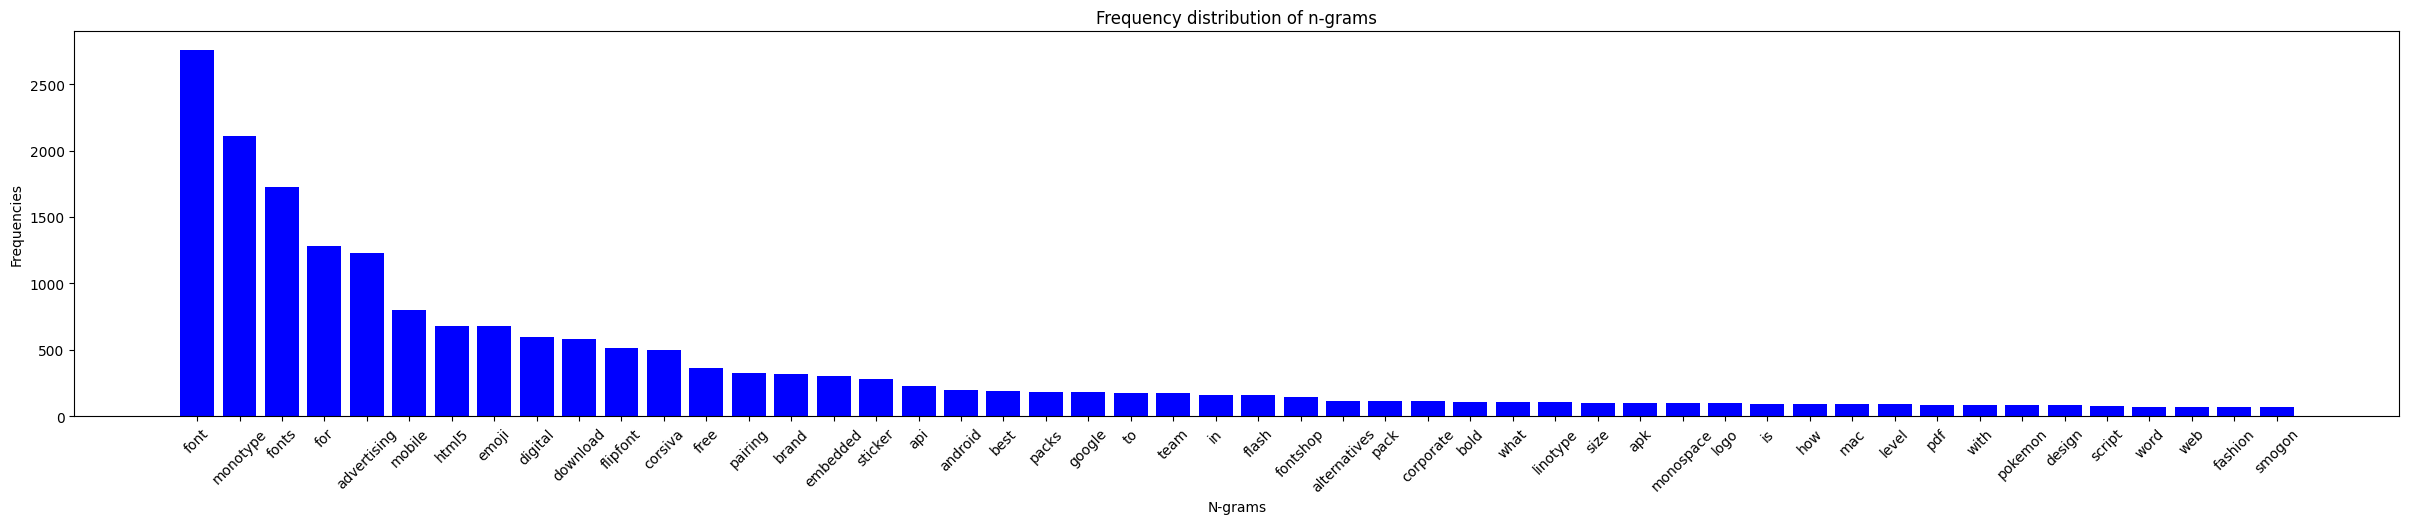

In [81]:
plot_frequency_distribution_of_ngrams(keywords.keyword)

Sample Length Distribution

In [101]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.figure(figsize=[10,5])
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample (chars)')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

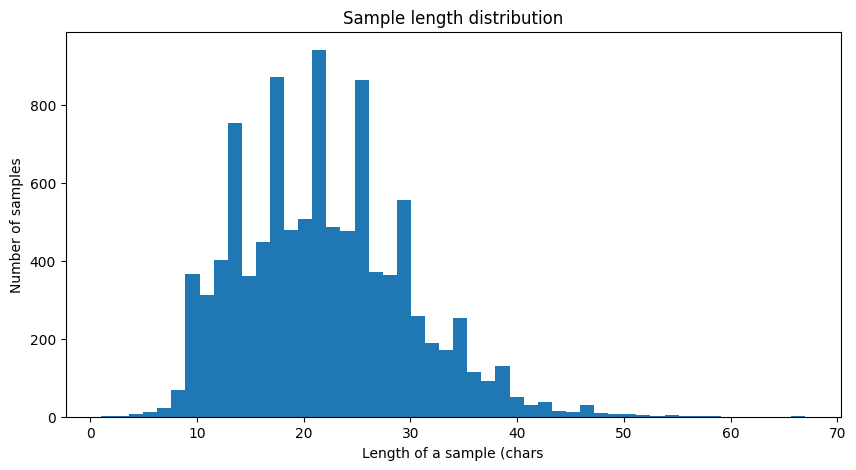

In [98]:
plot_sample_length_distribution(keywords.keyword)

Class Distribution

<AxesSubplot:xlabel='category'>

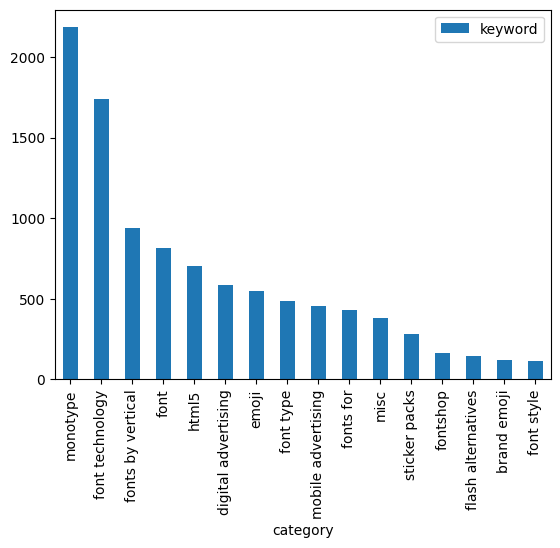

In [130]:
classes.plot.bar()

In [166]:
#TODO:Need to think about rewriting these exploratory scripts into something more succinct.

## Data Leakage

In [29]:
data_leakage = [row for row in zip(keywords.keyword,keywords.category) if row[0] == row[1]]
data_leakage_df = pd.DataFrame(columns = ['keyword', 'category'], data=data_leakage)

In [133]:
keywords = keywords[~(keywords.keyword + keywords.category).isin(data_leakage_df.keyword + data_leakage_df.category)]

## Class Imbalance

https://elitedatascience.com/imbalanced-classes

In [134]:
keywords

,keyword,category
0,writing fonts,font type
1,word fonts,font type
2,windows fonts,font type
3,wedding fonts,font type
4,wedding font,font type
...,...,...
10084,sticker pack yamaha bws 125,sticker packs
10085,sticker pack.zip,sticker packs
10086,obey sticker pack zumiez,sticker packs
10087,barbie stickerzine packs,sticker packs


In [161]:
item_counts = keywords.category.value_counts()

In [162]:
item_counts

monotype               2188
font technology        1740
fonts by vertical       936
font                    813
html5                   703
digital advertising     586
emoji                   547
font type               488
mobile advertising      457
fonts for               428
sticker packs           281
fontshop                166
flash alternatives      143
misc                    142
brand emoji             119
font style              112
linotype                 81
expertise                62
people                   32
swyft                    23
fontfont                 19
ITC                      15
bitstream                 4
ascender                  3
mobile sticker            1
Name: category, dtype: int64

### Rolling any class less < 100 into misc. 

In [164]:
for index,item in enumerate(keywords.category):
    if item_counts.loc[item]<100:
        keywords.category.iloc[index]='misc'

In [165]:
item_counts

monotype               2188
font technology        1740
fonts by vertical       936
font                    813
html5                   703
digital advertising     586
emoji                   547
font type               488
mobile advertising      457
fonts for               428
sticker packs           281
fontshop                166
flash alternatives      143
misc                    142
brand emoji             119
font style              112
linotype                 81
expertise                62
people                   32
swyft                    23
fontfont                 19
ITC                      15
bitstream                 4
ascender                  3
mobile sticker            1
Name: category, dtype: int64

Up sample Minorty Classes

Down sample majority classes